In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy

### Class to fill rectangles 

In [2]:
class fill_rectangles():
    """
    Class to fill rectangles in a space with two existing rectangles
    """
    def __init__(self, rect_H, rect_W, rect_h, rect_w, rect1_lb, rect2_lb):
        """
        Initializing the class variables
        
        Parameters: 
        rect_H (int): big rectangle height
        rect_W (int): big rectangle width
        rect_h (int): small rectangle height
        rect_w (int): small rectangle width
        rect1_lb (tuple): rectangle 1 left bottom point (x,y)
        rect2_lb (tuple): rectangle 2 left bottom point (x,y)
        """
        self.new_rectangles = []

        self.rect_H = rect_H
        self.rect_W = rect_W

        self.rect_h = rect_h
        self.rect_w = rect_w

        self.min_rect_dim = 10
        self.pad=5
        # all points in (x, y) format
#         origin = (0,0)

        # Left bottom points of initial two rectangles
        self.rect1_lb = rect1_lb
        self.rect2_lb = rect2_lb

        # Right top points of initial two rectangles 
        self.rect1_rt = (self.rect1_lb[0]+self.rect_w, self.rect1_lb[1]+self.rect_h)
        self.rect2_rt = (self.rect2_lb[0]+self.rect_w, self.rect2_lb[1]+self.rect_h)
        
        if (self.rect1_rt[1]>self.rect_H) or (self.rect2_rt[1]>self.rect_H):
            raise Exception("Inner rectangle height cannot be more than image height")
        if (self.rect1_rt[0]>self.rect_W) or (self.rect2_rt[0]>self.rect_W):
            raise Exception("Inner rectangle width cannot be more than image width")

        # Minimum and maximum x, y values
        self.min_x = min(self.rect1_lb[0], self.rect2_lb[0])
        self.min_y = min(self.rect1_lb[1], self.rect2_lb[1])
        self.max_x = max(self.rect1_rt[0], self.rect2_rt[0])
        self.max_y = max(self.rect1_rt[1], self.rect2_rt[1])
        # boundaries
        self.boundaries = [self.min_x, self.min_y, self.max_x, self.max_y]
        
        
    def check_boundary(self, boundaries, left=False, right=False, top=False, bottom=False):
        """
        Method to check if a new rectangle can be put near boundaries
        checks if a minumum side width rectangle can be accomodated
        """
        min_x, min_y, max_x, max_y = boundaries
        if left:
            if min_x>(self.min_rect_dim+2*self.pad):
#                 print("space found on left: ", min_x)
                return True
            else:
                return False
        if right:
            if (self.rect_W-max_x)>(self.min_rect_dim+2*self.pad):
#                 print("space found on right: ", self.rect_W-max_x)
                return True
            else:
                return False
        if top:
            if (self.rect_H-max_y)>(self.min_rect_dim+2*self.pad):
#                 print("space found on top: ", self.rect_H-max_y)
                return True
            else:
                return False
        if bottom:
            if min_y>(self.min_rect_dim+2*self.pad):
                return True
            else:
                return False
            
            
    def draw_boundary_rectangles(self, boundaries):
        """
        Draw new reactangles near boundaries if boundary conditions satisfy
        """
        recs = []
        rectangle = {"x": 0,"y": 0,"w": 0,"h": 0}    
        if self.check_boundary(boundaries, left=True):
            rectangle["x"] = 0+self.pad
            rectangle["y"] = 0+self.pad
            rectangle["w"] = self.min_x - (2*self.pad)
            rectangle["h"] = self.rect_H - (2*self.pad)
            left = copy.deepcopy(rectangle)
            recs.append(left)

        if self.check_boundary(boundaries, right=True):
            rectangle["x"] = self.max_x + self.pad
            rectangle["y"] = 0+self.pad
            rectangle["w"] = self.rect_W - self.max_x - (2*self.pad)
            rectangle["h"] = self.rect_H - (2*self.pad)
            right = copy.deepcopy(rectangle)
            recs.append(right)

        if self.check_boundary(boundaries, top=True):
#             print("Space on top")
            rectangle["x"] = self.min_x
            rectangle["y"] = self.max_y + self.pad
            rectangle["w"] = self.max_x - self.min_x
            rectangle["h"] = self.rect_H - self.max_y - self.pad
            top = copy.deepcopy(rectangle)
#             print("top: ", top)
            recs.append(top)

        if self.check_boundary(boundaries, bottom=True):
            rectangle["x"] = self.min_x
            rectangle["y"] = 0+self.pad
            rectangle["w"] = self.max_x-self.min_x
            rectangle["h"] = self.min_y-(2*self.pad)
            bottom = copy.deepcopy(rectangle)
            recs.append(bottom)
        return recs


    def is_left_up(self, rect1_lb, rect2_lb):
        """
        Method to check if left small rectangle is higher than the right rectangle 
        
        Parameters:
        rect1_lb: left bottom of 1st rect
        rect2_lb: left bottom of 2nd rect
        """
        if rect1_lb[0]<rect2_lb[0]:
            left_box = rect1_lb
            right_box = rect2_lb
        else:
            left_box = rect2_lb
            right_box = rect1_lb
        if left_box[1]>right_box[1]:
            return True
        else:
            return False
        
    
    def draw_all_rectangles(self):
        """
        Draws all possible rectangles based on the small rectangle positions
        """
        # Getting boundary rectangles based on "min rectangle side length" boundary condition
        if (self.rect1_lb[0]==self.rect2_lb[0]) or (self.rect1_lb[1]==self.rect2_lb[1]):
            boundary_recs = self.draw_boundary_rectangles(self.boundaries)
            self.new_rectangles.extend(boundary_recs)
            return self.new_rectangles
            
        boundary_recs = self.draw_boundary_rectangles(self.boundaries)
        self.new_rectangles.extend(boundary_recs)

        if self.is_left_up(self.rect1_lb, self.rect2_lb):
            box1 = {}
            box1["x"] = min(self.rect1_rt[0], self.rect2_rt[0])+self.pad
            box1["y"] = min(self.rect1_rt[1], self.rect2_rt[1])+self.pad
            box1["w"] = abs(self.rect1_rt[0] - self.rect2_rt[0])-self.pad
            box1["h"] = abs(self.rect1_rt[1] - self.rect2_rt[1])-self.pad
            self.new_rectangles.append(box1)
            
            # condition to check if there is side overlap
            if max(self.rect1_lb[0], self.rect2_lb[0]) > self.min_x+self.rect_w+(2*self.pad):
                box3 = {}
                box3["x"] = self.min_x
                box3["y"] = self.min_y
                box3["w"] = self.rect_w
                box3["h"] = max(self.rect1_lb[1], self.rect2_lb[1]) - self.min_y - self.pad
                self.new_rectangles.append(box3)
                
                box2 = {}
                box2["x"] = min(self.rect1_rt[0], self.rect2_rt[0])+self.pad
                box2["y"] = self.min_y
                box2["w"] = max(self.rect1_lb[0], self.rect2_lb[0])-min(self.rect1_rt[0], self.rect2_rt[0])-(2*self.pad)
                box2["h"] = self.rect_h
                self.new_rectangles.append(box2)
            else:
                box2 = {}
                box2["x"] = self.min_x
                box2["y"] = self.min_y
                box2["w"] = abs(self.rect1_lb[0] - self.rect2_lb[0])-self.pad
                box2["h"] = abs(self.rect1_lb[1] - self.rect2_lb[1])-self.pad
                self.new_rectangles.append(box2)
             
        else:
            box1 = {}
            box1["x"] = self.min_x
            box1["y"] = min(self.rect1_rt[1], self.rect2_rt[1])+self.pad
            box1["w"] = abs(self.rect1_lb[0] - self.rect2_lb[0])-self.pad
            box1["h"] = abs(self.rect1_rt[1] - self.rect2_rt[1])-self.pad
            self.new_rectangles.append(box1)
            
            # condition to check if there is side overlap
            if max(self.rect1_lb[0], self.rect2_lb[0])>self.min_x+self.rect_w+(2*self.pad):
                box3 = {}
                box3["x"] = max(self.rect1_lb[0], self.rect2_lb[0])
                box3["y"] = self.min_y
                box3["w"] = self.rect_w
                box3["h"] = max(self.rect1_lb[1], self.rect2_lb[1])-self.min_y-self.pad
                self.new_rectangles.append(box3)
                
                box2 = {}
                box2["x"] = min(self.rect1_rt[0], self.rect2_rt[0])+self.pad
                box2["y"] = self.min_y
                box2["w"] = max(self.rect1_lb[0], self.rect2_lb[0])-min(self.rect1_rt[0], self.rect2_rt[0])-(2*self.pad)
                box2["h"] = self.rect_h
                self.new_rectangles.append(box2)
            else:  
                
                box2 = {}
                box2["x"] = min(self.rect1_rt[0], self.rect2_rt[0])+self.pad
                box2["y"] = self.min_y
                box2["w"] = abs(self.rect1_rt[0] - self.rect2_rt[0])-self.pad
                box2["h"] = abs(self.rect1_lb[1] - self.rect2_lb[1])-self.pad
                self.new_rectangles.append(box2)
        
        return self.new_rectangles
    
    
    def visualize(self, all_recs):
        """
        Method to visualize all rectangles
        Parameters:
        
        all_recs (dict): all new rectangles found
        """
        o_h,o_w = self.rect_H, self.rect_W
        img_1 = np.zeros([o_h,o_w,3],dtype=np.uint8)
        img_1.fill(255)

        inner_rect_cord = [self.rect1_lb, self.rect2_lb]

        for i in inner_rect_cord:
            cv2.rectangle(img_1, i, (i[0]+rec.rect_w, i[1]+rec.rect_h), (255, 0, 0), 6)

        for i in all_recs:
            cv2.rectangle(img_1, (i['x'], i['y']), (i['x']+i['w'], i['y']+i['h']), (0, 0, 255), 3)

        img = img_1[:,:,::-1]
        plt.imshow(img_1)
        plt.gca().invert_yaxis()
        plt.show()

    



### Method results on different input configurations

6 new rectangles found:  [{'x': 505, 'y': 5, 'w': 90, 'h': 490}, {'x': 0, 'y': 355, 'w': 500, 'h': 145}, {'x': 0, 'y': 5, 'w': 500, 'h': 90}, {'x': 0, 'y': 205, 'w': 295, 'h': 145}, {'x': 300, 'y': 100, 'w': 200, 'h': 145}, {'x': 205, 'y': 100, 'w': 90, 'h': 100}]


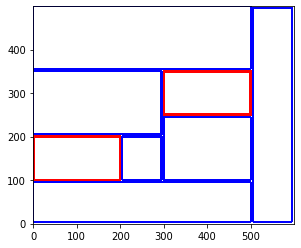

In [3]:
rec = fill_rectangles(rect_H=500, rect_W=600, rect_h=100, rect_w=200, rect1_lb=(0,100), rect2_lb=(300,250))
all_recs = rec.draw_all_rectangles()
print(f"{len(all_recs)} new rectangles found: ", all_recs)
rec.visualize(all_recs)

6 new rectangles found:  [{'x': 405, 'y': 5, 'w': 90, 'h': 490}, {'x': 0, 'y': 405, 'w': 400, 'h': 95}, {'x': 0, 'y': 5, 'w': 400, 'h': 140}, {'x': 105, 'y': 255, 'w': 295, 'h': 145}, {'x': 0, 'y': 150, 'w': 100, 'h': 145}, {'x': 105, 'y': 150, 'w': 190, 'h': 100}]


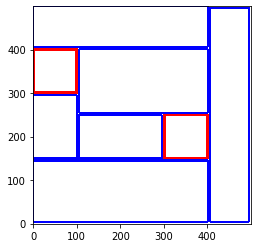

In [4]:
rec = fill_rectangles(rect_H=500, rect_W=500, rect_h=100, rect_w=100, rect1_lb=(0,300), rect2_lb=(300,150))
all_recs = rec.draw_all_rectangles()
print(f"{len(all_recs)} new rectangles found: ", all_recs)
rec.visualize(all_recs)

5 new rectangles found:  [{'x': 5, 'y': 5, 'w': 190, 'h': 490}, {'x': 200, 'y': 305, 'w': 300, 'h': 195}, {'x': 200, 'y': 5, 'w': 300, 'h': 140}, {'x': 405, 'y': 255, 'w': 95, 'h': 45}, {'x': 200, 'y': 150, 'w': 95, 'h': 45}]


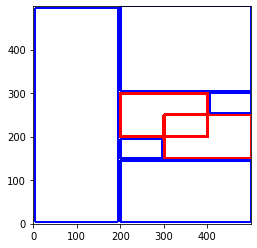

In [5]:
rec = fill_rectangles(rect_H=500, rect_W=500, rect_h=100, rect_w=200, rect1_lb=(200,200), rect2_lb=(300,150))
all_recs = rec.draw_all_rectangles()
print(f"{len(all_recs)} new rectangles found: ", all_recs)
rec.visualize(all_recs)

7 new rectangles found:  [{'x': 5, 'y': 5, 'w': 90, 'h': 490}, {'x': 405, 'y': 5, 'w': 90, 'h': 490}, {'x': 100, 'y': 455, 'w': 300, 'h': 45}, {'x': 100, 'y': 5, 'w': 300, 'h': 190}, {'x': 100, 'y': 305, 'w': 195, 'h': 145}, {'x': 300, 'y': 200, 'w': 100, 'h': 145}, {'x': 205, 'y': 200, 'w': 90, 'h': 100}]


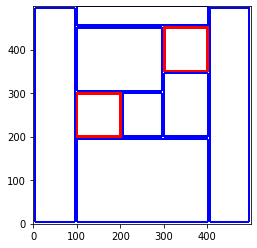

In [6]:
rec = fill_rectangles(rect_H=500, rect_W=500, rect_h=100, rect_w=100, rect1_lb=(100,200), rect2_lb=(300,350))
all_recs = rec.draw_all_rectangles()
print(f"{len(all_recs)} new rectangles found: ", all_recs)
rec.visualize(all_recs)

4 new rectangles found:  [{'x': 0, 'y': 5, 'w': 500, 'h': 190}, {'x': 0, 'y': 355, 'w': 395, 'h': 145}, {'x': 400, 'y': 200, 'w': 100, 'h': 145}, {'x': 105, 'y': 200, 'w': 290, 'h': 150}]


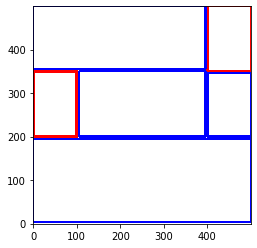

In [7]:
rec = fill_rectangles(rect_H=500, rect_W=500, rect_h=150, rect_w=100, rect1_lb=(0,200), rect2_lb=(400,350))
all_recs = rec.draw_all_rectangles()
print(f"{len(all_recs)} new rectangles found: ", all_recs)
rec.visualize(all_recs)

3 new rectangles found:  [{'x': 105, 'y': 105, 'w': 395, 'h': 395}, {'x': 0, 'y': 0, 'w': 100, 'h': 395}, {'x': 105, 'y': 0, 'w': 290, 'h': 100}]


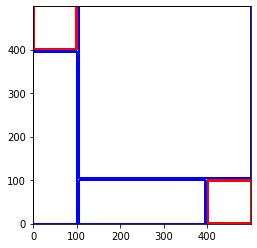

In [8]:
rec = fill_rectangles(rect_H=500, rect_W=500, rect_h=100, rect_w=100, rect1_lb=(0,400), rect2_lb=(400,0))
all_recs = rec.draw_all_rectangles()
print(f"{len(all_recs)} new rectangles found: ", all_recs)
rec.visualize(all_recs)

4 new rectangles found:  [{'x': 5, 'y': 5, 'w': 90, 'h': 490}, {'x': 405, 'y': 5, 'w': 90, 'h': 490}, {'x': 100, 'y': 305, 'w': 300, 'h': 195}, {'x': 100, 'y': 5, 'w': 300, 'h': 190}]


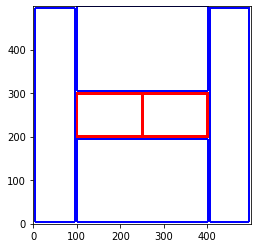

In [9]:
rec = fill_rectangles(rect_H=500, rect_W=500, rect_h=100, rect_w=150, rect1_lb=(100,200), rect2_lb=(250,200))
all_recs = rec.draw_all_rectangles()
print(f"{len(all_recs)} new rectangles found: ", all_recs)
rec.visualize(all_recs)

### Raise Exception when inner rectangle dimentions exceeds outer rectangle dimentions

In [10]:
rec = fill_rectangles(rect_H=500, rect_W=500, rect_h=150, rect_w=300, rect1_lb=(0,200), rect2_lb=(400,350))
all_recs = rec.draw_all_rectangles()
print(f"{len(all_recs)} new rectangles found: ", all_recs)
rec.visualize(all_recs)

Exception: Inner rectangle width cannot be more than image width